In [1]:

#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf 
print ("Done")

Done


# Importing Data 

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [2]:
#preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


# preprocessing

In [3]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)
    

In [4]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [5]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',
                             8:'Surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  Surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   Neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   Disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   Disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   Neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     Fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    Angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      Sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  Disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    Angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Surprise    192
Disgust     192
Fear        192
Sad         192
Calm        192
Happy       192
Angry       192
Neutral      96
Name: Emo

>*                           Data Visualisation and Exploration

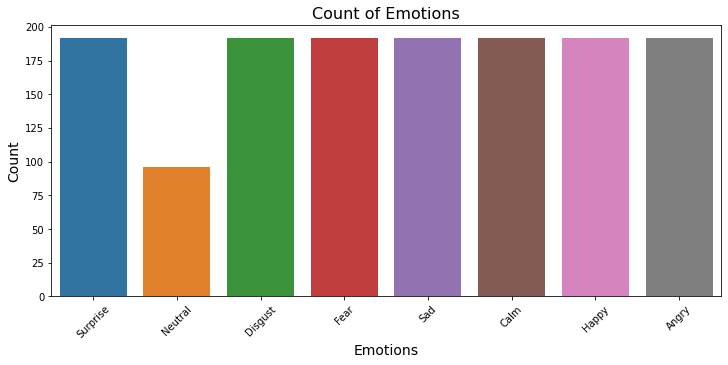

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(ravdess_df.Emotions)
plt.ylabel('Count', size=14)
plt.xlabel('Emotions', size=14)
plt.xticks(rotation=45)
plt.show()

In [7]:
data,sr = librosa.load(file_path[0])
sr

22050

In [8]:
ipd.Audio(data,rate=sr)

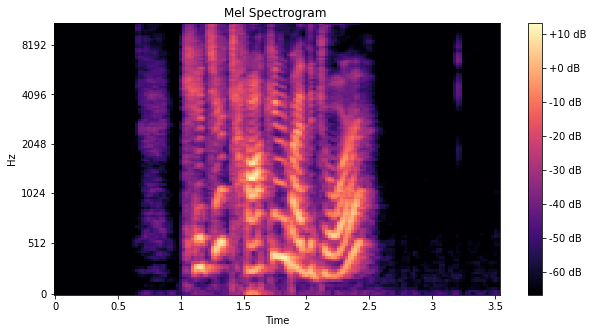

In [9]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

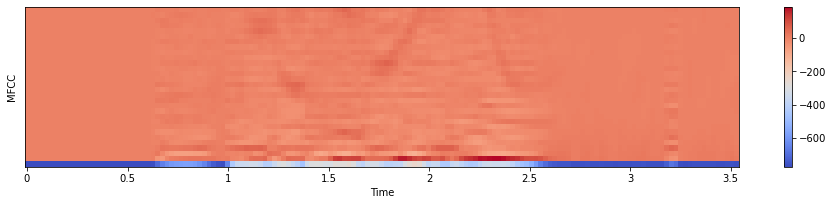

In [10]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [11]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

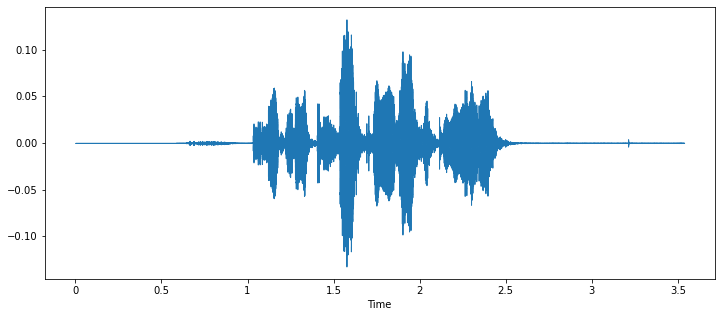

In [12]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

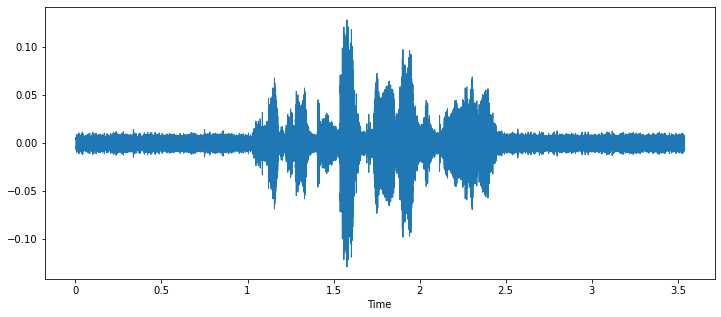

In [13]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

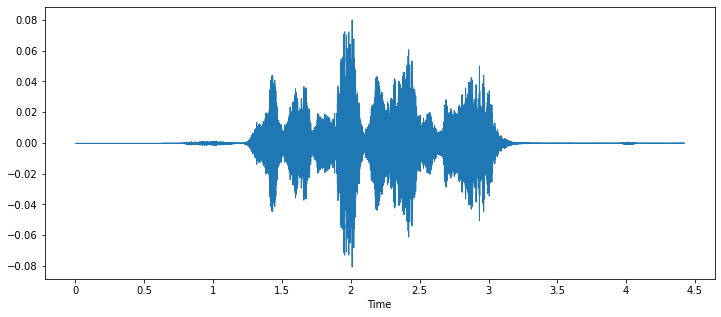

In [14]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

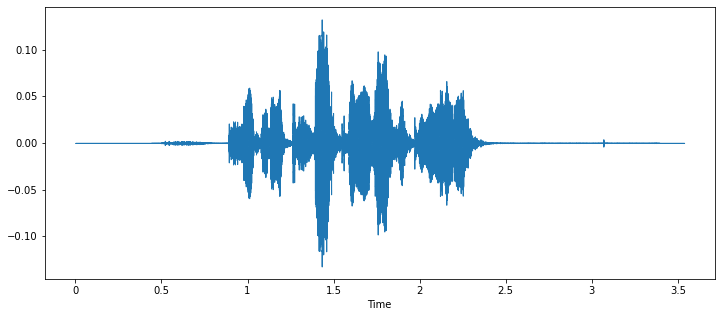

In [15]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

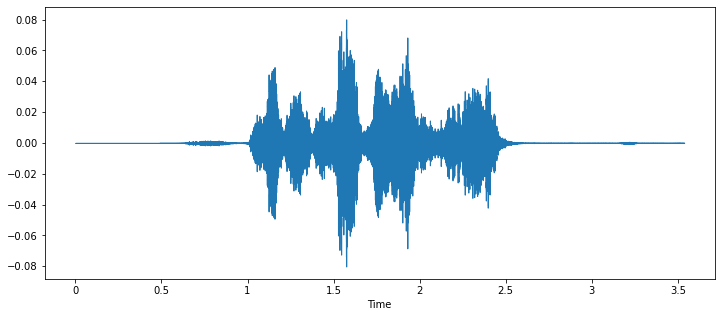

In [16]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [17]:
def feat_ext(data):
    #Time_domain_features
    # ZCR Persody features or Low level ascoustic features
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    #Frequency_domain_features
    #Spectral and wavelet Features
    #MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr,n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    return result

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result


In [18]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


# Noraml way to get features

In [19]:
#from joblib import Parallel, delayed
#import timeit
#start = timeit.default_timer()
#X , Y = [], []
#for path, emotion in zip(ravdess_df['Path'] , ravdess_df['Emotions']):
    #feature = get_feat(path)
   # for ele in feature:
   #     X.append(ele)
   #     Y.append(emotion)
#stop = timeit.default_timer()

#print('Time: ', stop - start)         

# Faster way to get features
***Parallel way***

**Dont be afraid from red lines that not Normal**


* In this modified code, the get_features function is defined to get features for a single audio file. The function takes the file path and its corresponding emotion as input and returns two lists: X, which contains the features for the audio file, and Y, which contains the emotion label.

* Then, the Parallel function from joblib library is used to call the get_features function in parallel for all audio files. The n_jobs parameter is set to -1 to use all available CPU cores.

* Finally, the results from all parallel calls to get_features are concatenated into X and Y lists.

*  The .extend() method increases the length of the list by the number of elements that are provided to the method, so if you want to add multiple elements to the list, you can use this method.

In [20]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def get_features(path, emotion):
    feature = get_feat(path)
    X, Y = [], []
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return X, Y

# Call the get_features function in parallel for all audio files
X, Y = [], []
results = Parallel(n_jobs=-1)(delayed(get_features)(path, emotion) for path, emotion in zip(ravdess_df['Path'], ravdess_df['Emotions']))
for result in results:
    X.extend(result[0])
    Y.extend(result[1])
stop = timeit.default_timer()

print('Time: ', stop - start)    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Pass rate=0.8 as keyword args. From version 0

Time:  300.44431910599997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Pass rate=0.8 as keyword args. From version 0

# Saving features

In [21]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Emotions
0,0.231174,-500.137909,55.952839,-24.865055,14.254915,-13.550117,-9.326091,-8.016472,-5.943054,-7.337967,...,6.326487,-0.668463,3.968732,1.670750,6.147342,-0.126313,3.284965,0.946971,2.170575,Surprise
1,0.337339,-295.588299,17.251218,-2.738634,-1.738672,-5.072634,-4.573611,-2.071283,-3.597806,-5.490111,...,1.533074,0.322130,0.073959,0.908532,2.008585,0.916678,0.425308,1.035097,0.712093,Surprise
2,0.181695,-549.696655,51.550751,-28.924458,11.523273,-18.617363,-9.631254,-10.385431,-6.619806,-8.471962,...,2.686978,0.039269,5.565796,3.854508,3.874002,0.122976,3.547589,-1.026717,0.795455,Surprise
3,0.239882,-575.140137,76.800308,-18.862423,11.525290,-10.439837,-5.423667,-11.138725,-11.655869,-8.324319,...,4.820825,2.497834,6.439108,3.044816,4.036336,-2.539325,1.908371,-1.398299,1.052068,Neutral
4,0.275820,-443.185122,37.563508,-5.051076,0.581157,-6.259340,-7.735353,-9.016717,-10.624239,-7.322380,...,3.308604,4.548715,4.778704,4.073984,2.174015,-0.236648,0.309959,0.272211,-0.063364,Neutral


In [22]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Emotions
0,0.231174,-500.137909,55.952839,-24.865055,14.254915,-13.550117,-9.326091,-8.016472,-5.943054,-7.337967,...,6.326487,-0.668463,3.968732,1.670750,6.147342,-0.126313,3.284965,0.946971,2.170575,Surprise
1,0.337339,-295.588299,17.251218,-2.738634,-1.738672,-5.072634,-4.573611,-2.071283,-3.597806,-5.490111,...,1.533074,0.322130,0.073959,0.908532,2.008585,0.916678,0.425308,1.035097,0.712093,Surprise
2,0.181695,-549.696655,51.550751,-28.924458,11.523273,-18.617363,-9.631254,-10.385431,-6.619806,-8.471962,...,2.686978,0.039269,5.565796,3.854508,3.874002,0.122976,3.547589,-1.026717,0.795455,Surprise
3,0.239882,-575.140137,76.800308,-18.862423,11.525290,-10.439837,-5.423667,-11.138725,-11.655869,-8.324319,...,4.820825,2.497834,6.439108,3.044816,4.036336,-2.539325,1.908371,-1.398299,1.052068,Neutral
4,0.275820,-443.185122,37.563508,-5.051076,0.581157,-6.259340,-7.735353,-9.016717,-10.624239,-7.322380,...,3.308604,4.548715,4.778704,4.073984,2.174015,-0.236648,0.309959,0.272211,-0.063364,Neutral


# Data preparation

In [23]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [24]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [25]:
print(Y.shape)
X.shape

(4320, 8)


(4320, 41)

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 41), (3240, 8), (1080, 41), (1080, 8))

In [27]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [28]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 41), (3240, 8), (1080, 41), (1080, 8))

In [29]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,mode='auto')
es=EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

# LSTM Model

In [31]:
model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(LSTM(128))
model01.add(Dropout(0.2))
model01.add(Dense(8,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 41, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 41, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 41, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 41, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 41, 128)           1

In [34]:
hist=model01.fit(X_train, y_train,
            epochs=100,
            validation_data=(X_test, y_test),batch_size=65,
            verbose=1)

Epoch 1/100
50/50 [==============================] - 27s 540ms/step - loss: 1.5418 - accuracy: 0.4080 - val_loss: 1.5423 - val_accuracy: 0.4241
Epoch 2/100
50/50 [==============================] - 31s 624ms/step - loss: 1.5016 - accuracy: 0.4262 - val_loss: 1.4577 - val_accuracy: 0.4444
Epoch 3/100
50/50 [==============================] - 32s 645ms/step - loss: 1.4627 - accuracy: 0.4451 - val_loss: 1.4614 - val_accuracy: 0.4333
Epoch 4/100
50/50 [==============================] - 30s 573ms/step - loss: 1.4731 - accuracy: 0.4383 - val_loss: 1.4325 - val_accuracy: 0.4463
Epoch 5/100
50/50 [==============================] - 32s 639ms/step - loss: 1.4340 - accuracy: 0.4441 - val_loss: 1.4542 - val_accuracy: 0.4565
Epoch 6/100
50/50 [==============================] - 28s 566ms/step - loss: 1.4491 - accuracy: 0.4401 - val_loss: 1.4543 - val_accuracy: 0.4398
Epoch 7/100
50/50 [==============================] - 28s 556ms/step - loss: 1.4025 - accuracy: 0.4639 - val_loss: 1.4566 - val_accuracy:

34/34 [==============================] - 4s 110ms/step - loss: 1.2648 - accuracy: 0.6787
Accuracy of our model on test data :  67.87037253379822 %


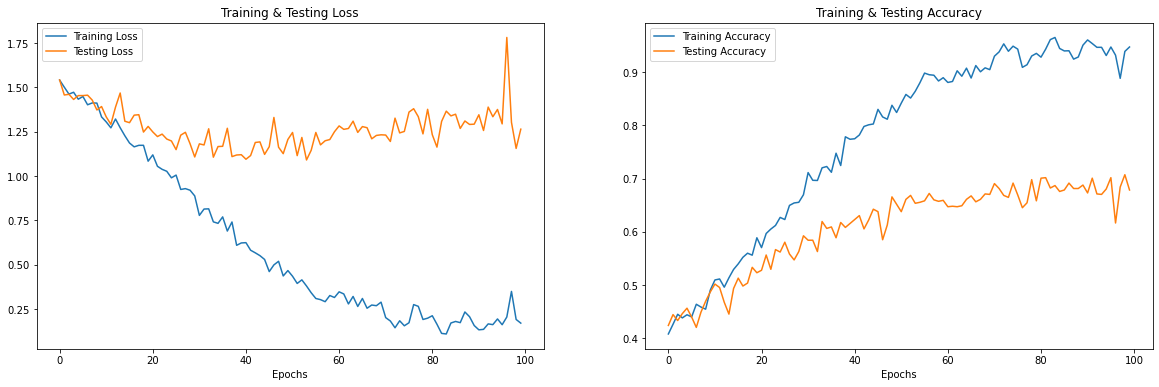

In [35]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# CNN model

In [42]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((3240, 41, 1), (3240, 8), (1080, 41, 1), (1080, 8))

In [ ]:
#CNN


model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model( model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [ ]:
#CNN
history =  model.fit(x_traincnn, y_train, batch_size=64, epochs=100, validation_data=(x_testcnn, y_test))

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

Some plots of multi_model
______________________________________________


In [ ]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [47]:
# predicting on test data.
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test1 = encoder.inverse_transform(y_test)

# Check for random predictions
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test1.flatten()

df.head(10)


NameError: name 'model' is not defined

# CLSTM Model

Another  model (CLSTM)  omnia model
_____________________________________________________

In [36]:
#Build the model

# define model
model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

          
model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))
          
model000.add(LSTM(128, return_sequences=True)) 
model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(8, activation='softmax'))



model000.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 41, 1024)          6144      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 21, 1024)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 1024)          4096      
_________________________________________________________________
dropout_7 (Dropout)          (None, 21, 1024)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 512)           2621952   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 512)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 512)          

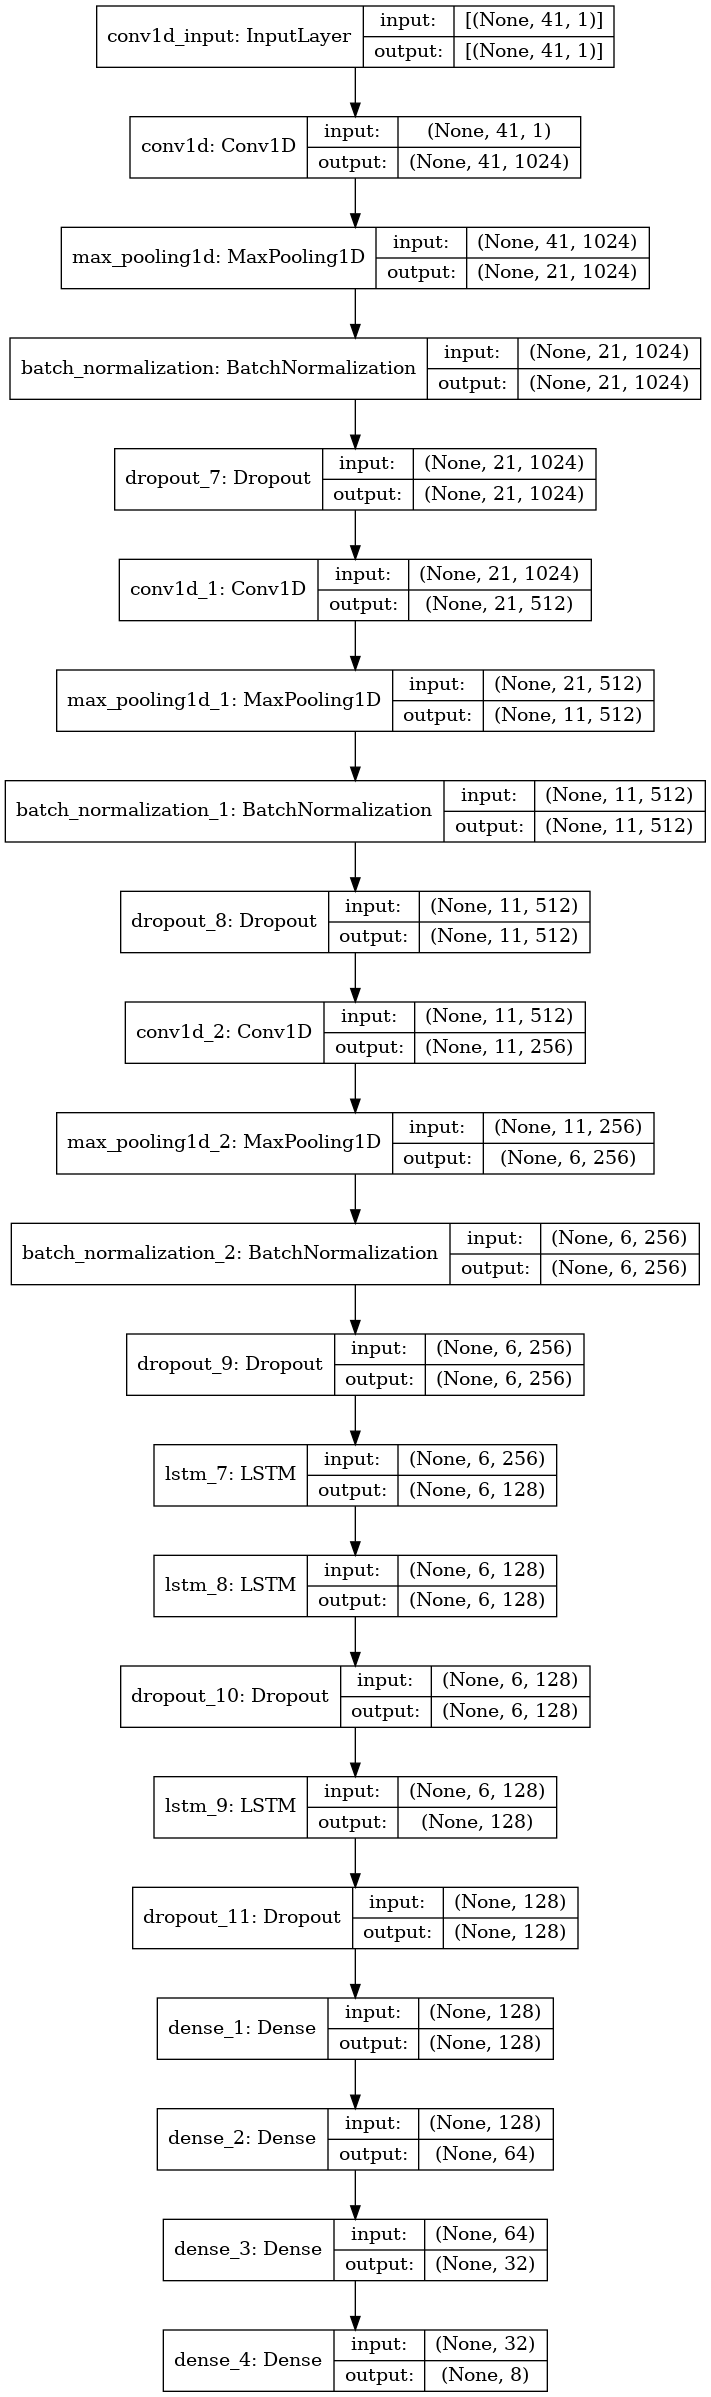

In [37]:
from keras.utils.vis_utils import plot_model
plot_model( model000, show_shapes=True, show_layer_names=True, to_file='model000.png')

In [39]:
model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
hist1=model000.fit(x_traincnn, y_train, batch_size=64, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
51/51 [==============================] - 33s 451ms/step - loss: 1.9851 - accuracy: 0.2299 - val_loss: 2.0816 - val_accuracy: 0.1306
Epoch 2/100
51/51 [==============================] - 22s 427ms/step - loss: 1.7558 - accuracy: 0.3358 - val_loss: 2.0432 - val_accuracy: 0.1500
Epoch 3/100
51/51 [==============================] - 23s 446ms/step - loss: 1.5961 - accuracy: 0.3963 - val_loss: 2.1077 - val_accuracy: 0.1722
Epoch 4/100
51/51 [==============================] - 21s 422ms/step - loss: 1.4542 - accuracy: 0.4444 - val_loss: 2.0878 - val_accuracy: 0.1537
Epoch 5/100
51/51 [==============================] - 21s 418ms/step - loss: 1.3146 - accuracy: 0.5108 - val_loss: 2.3589 - val_accuracy: 0.0944
Epoch 6/100
51/51 [==============================] - 21s 416ms/step - loss: 1.2188 - accuracy: 0.5457 - val_loss: 1.9197 - val_accuracy: 0.2657
Epoch 7/100
51/51 [==============================] - 22s 424ms/step - loss: 1.1024 - accuracy: 0.5895 - val_loss: 1.8794 - val_accuracy:

34/34 [==============================] - 2s 61ms/step - loss: 0.7705 - accuracy: 0.8324
Accuracy of our model on test data :  83.24074149131775 %


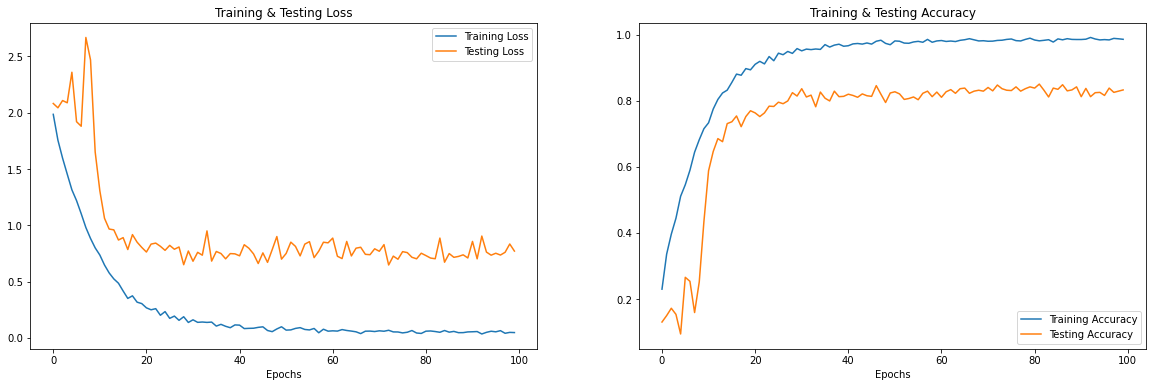

In [44]:
print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [48]:
# predicting on test data.
pred_test00 = model000.predict(x_testcnn)
y_pred00 = encoder.inverse_transform(pred_test)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)

NameError: name 'pred_test' is not defined

# Evalutation

In [49]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test00, y_pred00)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test00, y_pred00))

NameError: name 'y_test00' is not defined

# Saving Best Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model000.to_json()
with open("cnnlstmmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model000.save_weights("cnnlstmmodel000.h5")
print("Saved model to disk") 

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/cnnlstmmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/cnnlstmmodel000.h5")
print("Loaded model from disk")

In [ ]:
loaded_model.compile(optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

In [ ]:

import joblib

#saving scaler
joblib.dump(scaler, 'scaler.joblib')

#loading our scaler

scaler = joblib.load('scaler.joblib')

#saving our encoder

joblib.dump(encoder, 'encoder.joblib')

#loading our encoder

encoder= joblib.load('encoder.joblib')

# Predict function
* That can predict new record 

In [ ]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=feat_ext(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,41))
    i_result = scaler.transform(result)
    final_result=np.expand_dims(i_result, axis=2)
    
    return final_result

In [ ]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-02-01-02-01-01.wav")
print(res.shape)

In [ ]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder.inverse_transform(predictions)
    print(y_pred[0][0])    

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-04-02-01-01-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")